<a href="https://colab.research.google.com/github/deemoo0/PG-Project/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import Libraries


In [10]:
!pip install gensim
!pip install nltk
!pip install  tensorflow
!pip install  keras
!pip install  matplotlib

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt


Load Dataset


In [12]:
df = pd.read_csv(
    "/content/drive/MyDrive/training.1600000.processed.noemoticon.csv",
    encoding="latin-1",
    header=None
)

df.columns = ["sentiment", "id", "date", "query", "user", "text"]
df = df[["sentiment", "text"]]

df.head()


,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


3.NLP Setup

In [13]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("stopwords")

stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


4.Apply Cleaning

In [16]:
df_sample = df.sample(20000, random_state=42)
df_sample["clean_text"] = df_sample["text"].apply(clean_text)

df_sample.head()


,sentiment,text,clean_text
541200,0,@chrishasboobs AHHH I HOPE YOUR OK!!!,ahhh hope ok
750,0,"@misstoriblack cool , i have no tweet apps fo...",cool tweet apps razr
766711,0,@TiannaChaos i know just family drama. its la...,know family drama lamehey next time u hang kim...
285055,0,School email won't open and I have geography ...,school email wont open geography stuff revise ...
705995,0,upper airways problem,upper airways problem


5.demand mapping

In [17]:
def map_demand(sentiment):
    if sentiment == 4:
        return "High"
    elif sentiment == 2:
        return "Medium"
    else:
        return "Low"

df_sample["demand"] = df_sample["sentiment"].apply(map_demand)
df_sample["demand"].value_counts()


,count
demand,
High,10058
Low,9942


6.Tokenization for Word3Vec

In [18]:
from gensim.models import Word2Vec
sentences = [text.split() for text in df_sample["clean_text"]]


7.Train Word2Vec Model

In [19]:
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4
)


8.Check Word Embedding

In [20]:
w2v_model.wv.most_similar("good")


[('everyone', 0.997428297996521),
 ('great', 0.9972016215324402),
 ('wonderful', 0.9968879818916321),
 ('beautiful', 0.9968746900558472),
 ('hello', 0.9968588948249817),
 ('another', 0.996652364730835),
 ('afternoon', 0.9966432452201843),
 ('fine', 0.9966368675231934),
 ('monday', 0.9966228008270264),
 ('went', 0.9966135025024414)]

9.build sequence Matrix

In [21]:
MAX_LEN = 50
EMBEDDING_DIM = 100

def text_to_sequence(text):
    words = text.split()
    sequence = []
    for word in words[:MAX_LEN]:
        if word in w2v_model.wv:
            sequence.append(w2v_model.wv[word])
    if len(sequence) < MAX_LEN:
        sequence += [np.zeros(EMBEDDING_DIM)] * (MAX_LEN - len(sequence))
    return np.array(sequence)

X = np.array([text_to_sequence(text) for text in df_sample["clean_text"]])


10.encode Labels

In [22]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df_sample["demand"])

X.shape, y.shape


((20000, 50, 100), (20000,))

11A.first check

In [23]:
df_sample["clean_text"].isna().sum()


np.int64(0)

11B.Safe tokenization

In [24]:
from gensim.models import Word2Vec

sentences = []
for text in df_sample["clean_text"]:
    words = text.split()
    if len(words) > 2:
        sentences.append(words)

len(sentences)


17823

11C.Word2Vec Train

In [25]:
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=3,
    workers=4,
    sg=1
)


11D.Verify Model

In [26]:
w2v_model.wv.key_to_index.keys().__iter__().__next__()


'im'

11.train test split

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((16000, 50, 100), (4000, 50, 100))

12.import deep learning libs

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical


cell13
one hot encode output

In [29]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

y_train_cat.shape


(16000, 2)

14.build bilstm model

In [37]:
model = Sequential()

model.add(
    Bidirectional(
        LSTM(64, return_sequences=False),
        input_shape=(X.shape[1], X.shape[2])
    )
)

model.add(Dropout(0.5))
model.add(Dense(2, activation="softmax"))

model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,738 (331.01 KB)

 Trainable params: 84,738 (331.01 KB)

 Non-trainable params: 0 (0.00 B)

15 .train the model

In [38]:
history = model.fit(
    X_train,
    y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=5,
    batch_size=64
)


Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 92ms/step - accuracy: 0.5178 - loss: 0.6949 - val_accuracy: 0.5497 - val_loss: 0.6855
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - accuracy: 0.5374 - loss: 0.6886 - val_accuracy: 0.5650 - val_loss: 0.6805
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - accuracy: 0.5493 - loss: 0.6838 - val_accuracy: 0.5435 - val_loss: 0.6888
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.5514 - loss: 0.6839 - val_accuracy: 0.5665 - val_loss: 0.6741
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.5676 - loss: 0.6788 - val_accuracy: 0.5663 - val_loss: 0.6767


16.model evaluation

In [39]:
loss, accuracy = model.evaluate(X_test, y_test_cat)
accuracy


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5662 - loss: 0.6778


0.5662500262260437

17.accuracy gragh

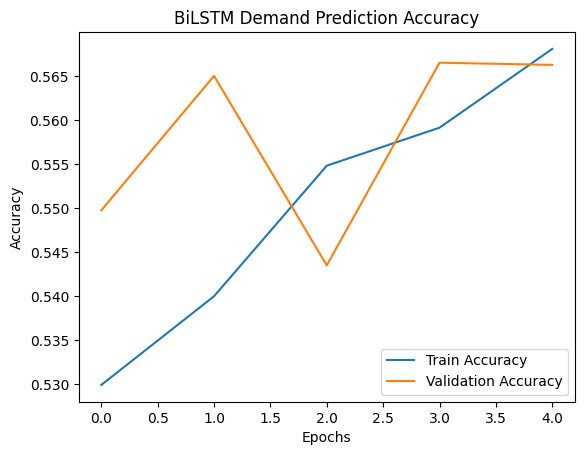

In [40]:
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("BiLSTM Demand Prediction Accuracy")
plt.show()
